In [40]:
import numpy as np
import pandas as pd
import sys, os, json, csv, pathlib as Path
from datetime import datetime, timedelta

from typing import Dict, List
import requests
import pandas as pd
from bs4 import BeautifulSoup
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [41]:
#creating path
DATA_RAW = pathlib.Path("data/raw")
DATA_RAW.mkdir(parents=True, exist_ok=True)

# Load .env
load_dotenv()
ALPHA_API_KEY = os.getenv("ALPHA_API_KEY")
print("Loaded ALPHA_API_KEY?", bool(ALPHA_API_KEY))

Loaded ALPHA_API_KEY? True


In [43]:
SYMBOL = "XAU"
use_alpha = bool(ALPHA_API_KEY)

if not use_alpha:
    print("No Alpha Vantage API key found — currently falling back to APMEX")

if use_alpha: #Using API to pull out values
    url = "https://www.alphavantage.co/query"
    parameters = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",      
        "symbol": SYMBOL,
        "outputsize": "compact",     # compact - last 100 value; full - all historical value
        "apikey": ALPHA_API_KEY,
        "datatype": "json"
    }
    
    r = requests.get(url, params=parameters, timeout=30)
    r.raise_for_status()
    data = r.json()
    
    if "Information" in data:
        raise RuntimeError({data['Information']})
    if "Error Message" in data:
        raise RuntimeError( {data['Error Message']})


    key = [k for k in data.keys() if "Time Series" in k]
    
    assert key, f"Unexpected response keys: {list(data.keys())}"
    series = data[key[0]]
    
    df = (
        pd.DataFrame(series).T
        .rename_axis("date")
        .reset_index()
    )

    df = df[['date', '1. open', '2. high', '3. low', '4. close','5. volume']].rename(
        columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
        })

    df['date'] = pd.to_datetime(df['date'])
    for col in ['open','high','low','close','volume']:
        df[col] = pd.to_numeric(df[col])

else: #use yahoofinance
    TICKER = "GC=F"
    import yfinance as yf 
    df = (yf.download(SYMBOL, period="6mo", interval="1d").reset_index())[['Date','Open','High','Low','Close','Volume']]
        

df = df.sort_values('date').reset_index(drop=True)

msgs = validate_df(
    df,
    required_cols=['date','open','high','low','close','volume'],
    dtypes_map={
        'date':'datetime64[ns]',
        'open':'float',
        'high':'float',
        'low':'float',
        'close':'float',
        'volume':'float'
    })
print(msgs)

file_name = safe_filename(prefix="api", meta={"source": "alpha" 
                                              if use_alpha 
                                              else "YahooFinance", "symbol": 'AAPL'})

out_path = DATA_RAW/file_name #saving it somewhere
df.to_csv(out_path, index=False)
print("Saved:", out_path)

RuntimeError: {'Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints'}

## Importing Data and Save
Uncleaned csv file of gold price, usd_index, crude oil, S&P 500, Bitcoin Price

In [46]:
import yfinance as yf

# 1. Setup: Define tickers & output folder
tickers = {
    "gold": "GC=F",        # Gold Futures
    "usd_index": "DX-Y.NYB", # US Dollar Index
    "crude_oil": "CL=F",     # Crude Oil
    "sp500": "^GSPC",        # S&P 500 Index
    "bitcoin": "BTC-USD"     # Bitcoin
}

#creating path
DATA_RAW = pathlib.Path("data/raw")
DATA_PROC = pathlib.Path("data/processed")
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROC.mkdir(parents=True, exist_ok=True)

# 2. Pull data for 1 year
data = {}
for name, symbol in tickers.items():
    print(f"Pulling {name} ({symbol}) ...")
    try:
        df = yf.download(symbol, period="1y", interval="1d")[["Close"]]
        df = df.rename(columns={"Close": name})
        data[name] = df
    except Exception as e:
        print(f"Failed to download {name}: {e}")

# 3. Merge all tickers on date (outer join keeps all dates)
df_all = pd.concat(data.values(), axis=1, join="outer")
df_all = df_all.reset_index().rename(columns={"Date": "date"})

# 4. Sort dates & forward fill missing values
df_all['date'] = pd.to_datetime(df_all['date'])
df_all = df_all.sort_values('date').reset_index(drop=True)
print("\nMissing values per column before fill:")
print(df_all.isna().sum())

df_all = df_all.ffill()  # forward-fill weekends/holidays

# 5. Save to CSV
out_path = DATA_RAW / "gold_and_comparison_factors.csv"
df_all.to_csv(out_path, index=False)
print(f"\nData saved to {out_path}")

Pulling gold (GC=F) ...


/var/folders/zp/cxqlz1xd78bcshll8_fr_byw0000gn/T/ipykernel_29057/1363734568.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1y", interval="1d")[["Close"]]
[*********************100%***********************]  1 of 1 completed
/var/folders/zp/cxqlz1xd78bcshll8_fr_byw0000gn/T/ipykernel_29057/1363734568.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1y", interval="1d")[["Close"]]


Pulling usd_index (DX-Y.NYB) ...


[*********************100%***********************]  1 of 1 completed
/var/folders/zp/cxqlz1xd78bcshll8_fr_byw0000gn/T/ipykernel_29057/1363734568.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1y", interval="1d")[["Close"]]


Pulling crude_oil (CL=F) ...


[*********************100%***********************]  1 of 1 completed
/var/folders/zp/cxqlz1xd78bcshll8_fr_byw0000gn/T/ipykernel_29057/1363734568.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1y", interval="1d")[["Close"]]


Pulling sp500 (^GSPC) ...


[*********************100%***********************]  1 of 1 completed
/var/folders/zp/cxqlz1xd78bcshll8_fr_byw0000gn/T/ipykernel_29057/1363734568.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1y", interval="1d")[["Close"]]


Pulling bitcoin (BTC-USD) ...


[*********************100%***********************]  1 of 1 completed


Missing values per column before fill:
Price      Ticker  
date                     0
gold       GC=F        113
usd_index  DX-Y.NYB    113
crude_oil  CL=F        113
sp500      ^GSPC       115
bitcoin    BTC-USD       0
dtype: int64

Data saved to data/raw/gold_and_comparison_factors.csv


## Summary of Uncleaned Data
1. Summary Statistics
2. information
3. mussing values
4. scatter plot (x-value = gold)
5. correlation heatmap
6. Other Visualizations

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the saved data
df = pd.read_csv("data/raw/gold_and_comparison_factors.csv", parse_dates=["date"])

# 2. Quick look at missing values
print("--------------------------")
print("Missing values per column:")
print("--------------------------")
print(df.isna().sum())

# 3. Summary statistics
print("--------------------------")
print(df.dtypes)
print("--------------------------")


# Convert all columns except 'date' to numeric
for col in df.columns:
    if col != 'date':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Directly compute mean, median, std for each column
summary_stats = df.select_dtypes(include='number').agg(['mean', 'median', 'std']).T
print(summary_stats)
print("--------------------------")

print("\nSummary statistics (mean, median, std):")
print(summary_stats)


--------------------------
Missing values per column:
--------------------------
date         1
gold         0
usd_index    0
crude_oil    0
sp500        0
bitcoin      0
dtype: int64
--------------------------
date         datetime64[ns]
gold                 object
usd_index            object
crude_oil            object
sp500                object
bitcoin              object
dtype: object
--------------------------
                   mean        median           std
gold        2970.851638   2913.599976    313.466753
usd_index    102.734773    102.545002      3.815327
crude_oil     68.233743     68.480000      4.446094
sp500       5908.470234   5939.879883    290.115652
bitcoin    92812.401266  96496.214844  17543.353541
--------------------------

Summary statistics (mean, median, std):
                   mean        median           std
gold        2970.851638   2913.599976    313.466753
usd_index    102.734773    102.545002      3.815327
crude_oil     68.233743     68.480000      4

In [ ]:
def detect_outliers_iqr(series: pd.Series, iqr_mult: float = 1.5) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce") 
    #coerce -->values cant convert to number are replaced by NaN, not considered into any future formulas
    # s = all values shoul be numbers or NaN
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr_mult * iqr
    upper = q3 + iqr_mult * iqr
    return (s < lower) | (s > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    mu = s.mean()
    stdev = s.std(ddof=0)
    if stdev == 0 or np.isnan(stdev):
        return pd.Series(False, index=s.index)
    z = (s - mu) / stdev
    return z.abs() > threshold
    
    
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    if not (0 <= lower < upper <= 1):
        raise ValueError("Quantiles must satisfy 0 <= lower < upper <= 1")
        
    s = pd.to_numeric(series, errors="coerce")
    low = s.quantile(lower)
    high = s.quantile(upper)
    return s.clip(lower=low, upper=high)

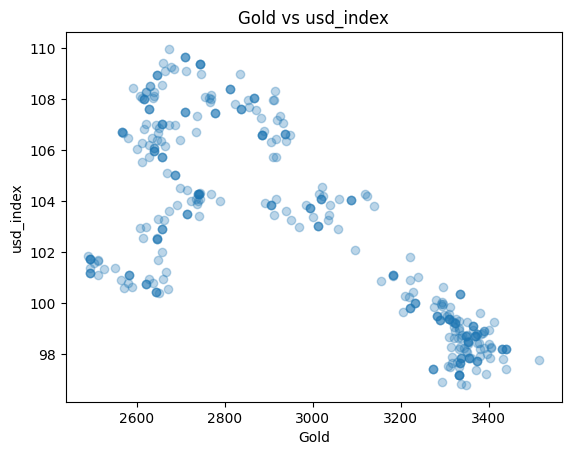

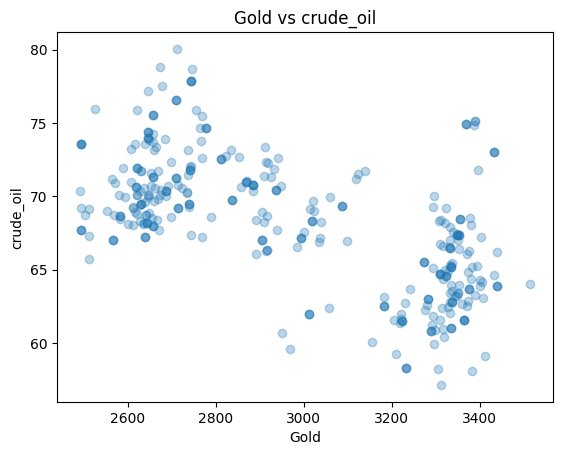

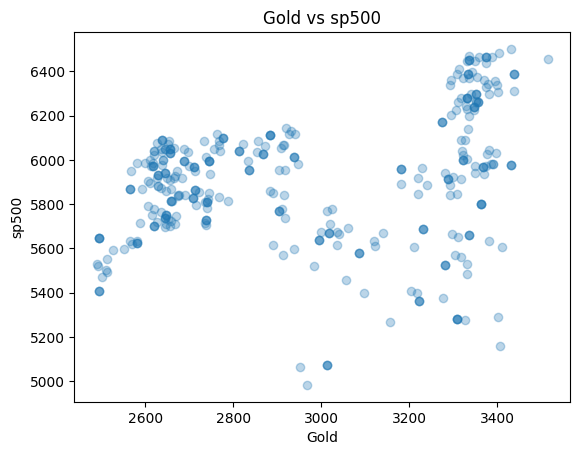

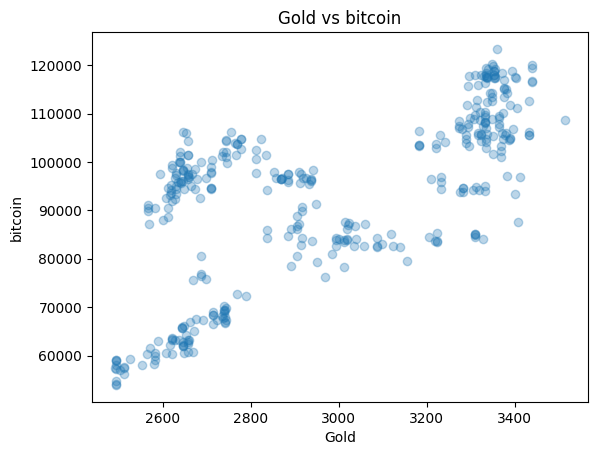


Correlation with Gold:
--------------------------
gold         1.000000
date         0.948426
bitcoin      0.679510
sp500        0.287038
crude_oil   -0.615040
usd_index   -0.742016
Name: gold, dtype: float64


In [64]:
# 5. Simple scatter plots: gold vs each factor
factors = [c for c in df.columns if c not in ["date", "gold"]]

for factor in factors:
    plt.scatter(df["gold"],df[factor],alpha=0.3)
    
    plt.title(f"Gold vs {factor}")
    plt.ylabel(factor)
    plt.xlabel("Gold")
    plt.show()

# 4. Correlation with gold prices
corr = df.corr()["gold"].sort_values(ascending=False)
print("\nCorrelation with Gold:")
print("--------------------------")
print(corr)

In [65]:
#linear Regression
df = df.dropna()

# Train/Test Split 
x = df.drop(columns=['date', 'gold'])   # all factors except gold
y = df['gold']                          # gold only - all other factors compared to gold

# Fit Linear Regression 
model = LinearRegression()
model.fit(x, y)

# 5. Predictions & metrics
y_pred = model.predict(x)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

# 6. Print results
print("Coefficients:")
print(pd.Series(model.coef_, index=x.columns))
print(f"Intercept: {model.intercept_:.2f}")
print(f"R²: {r2:.3f}, MAE: {mae:.3f}")

plt.tight_layout()
plt.show()

Coefficients:
usd_index   -50.473085
crude_oil     1.202951
sp500        -0.351553
bitcoin       0.013792
dtype: float64
Intercept: 8871.17
R²: 0.876, MAE: 89.617


<Figure size 640x480 with 0 Axes>

In [66]:
# Make sure numeric only
df_numeric = df.drop(columns=['date'])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.dropna()

# Correlation with gold
corr = df_numeric.corr()['gold'].drop('gold').sort_values(key=abs, ascending=False)

print("Correlation of each feature with gold:")
print(corr)

Correlation of each feature with gold:
usd_index   -0.742016
bitcoin      0.679510
crude_oil   -0.615040
sp500        0.287038
Name: gold, dtype: float64


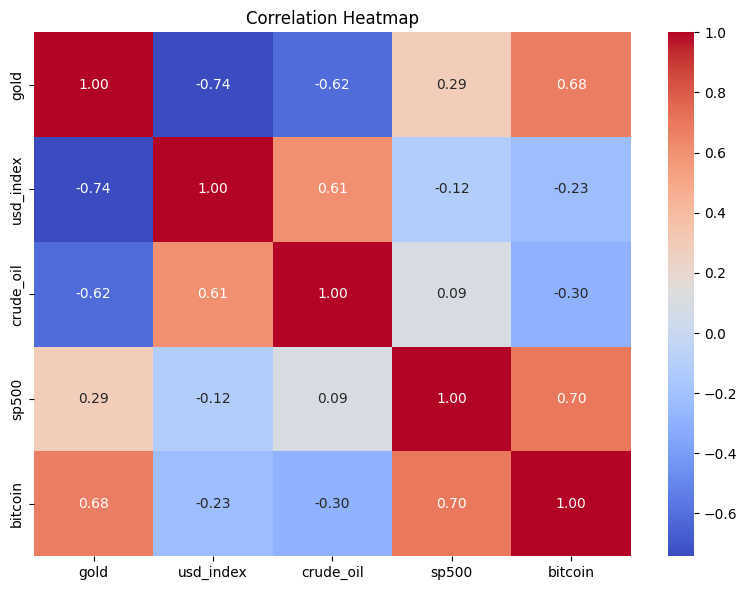

In [67]:
#HEATMAP - visualization of correlation

# 1. Convert to numeric & drop NAs
df_numeric = df.drop(columns=['date'])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce').dropna()

# 2. Compute correlation matrix
corr_matrix = df_numeric.corr()

# 3. Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

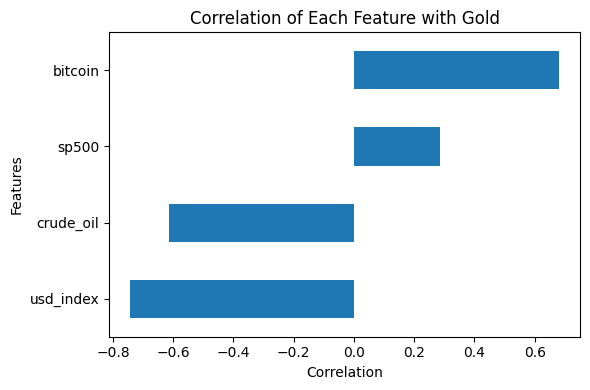

In [68]:
# 1. Numeric only, drop NAN
df_numeric = df.drop(columns=['date'])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce').dropna()

# 2. Correlation with gold only
corr_gold = df_numeric.corr()['gold'].drop('gold').sort_values()

# 3. Bar chart
plt.figure(figsize=(6, 4))
corr_gold.plot(kind='barh')
plt.title("Correlation of Each Feature with Gold")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## Forecasting gold price


Evaluation on test set:
                      mae     rmse     r2
LinearRegression  18.8404  26.9121  0.588


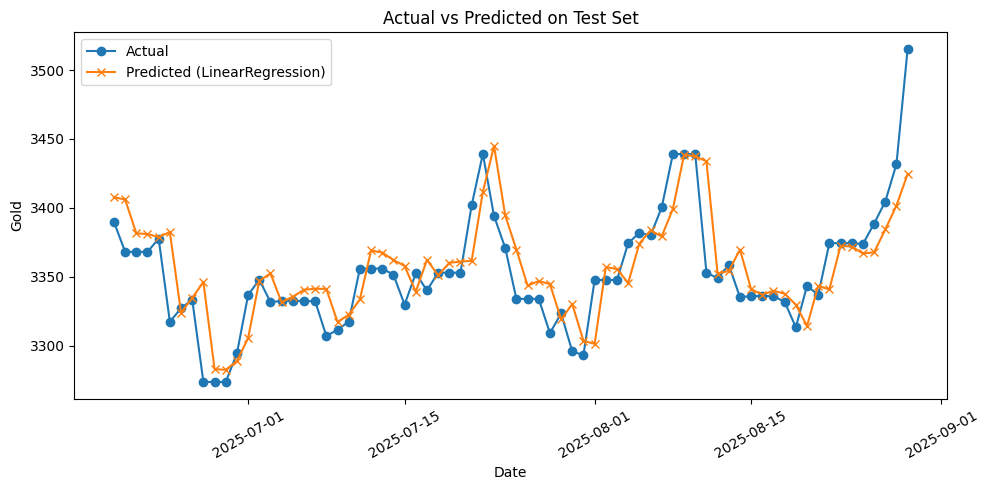

In [89]:
df2 = df.copy()
for col in df2.columns:
    if col != "date":
        df2[col] = pd.to_numeric(df2[col], errors="coerce")
df2 = df2.dropna().sort_values("date").reset_index(drop=True)

# Config
target = "gold"
exog = [c for c in df2.columns if c not in ("date", target)]
n_lags = 5
test_frac = 0.2
forecast_horizon = 14  # days to forecast

# Create lag features
for lag in range(1, n_lags + 1):
    df2[f"gold_lag_{lag}"] = df2[target].shift(lag)

# Drop rows with NA lags
df2 = df2.dropna().reset_index(drop=True)

# Feature matrix
lag_cols = [f"gold_lag_{lag}" for lag in range(1, n_lags + 1)]
feature_cols = lag_cols + exog

# --------------------------
# Train-test split
# --------------------------
n = len(df2)
test_n = max(forecast_horizon, int(n * test_frac))
train_df = df2.iloc[:-test_n]
test_df  = df2.iloc[-test_n:]

X_train = train_df[feature_cols].values
y_train = train_df[target].values
X_test  = test_df[feature_cols].values
y_test  = test_df[target].values
dates_test = test_df["date"]

# --------------------------
# Model training & evaluation
# --------------------------
models = {
    "LinearRegression": LinearRegression()
}

fitted = {}
preds = {}
metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    preds[name] = yhat
    fitted[name] = model
    mae = mean_absolute_error(y_test, yhat)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    r2  = r2_score(y_test, yhat)
    metrics[name] = {"mae": mae, "rmse": rmse, "r2": r2}

# Show metrics
metrics_df = pd.DataFrame(metrics).T[["mae", "rmse", "r2"]]
print("\nEvaluation on test set:")
print(metrics_df.round(4))

# --------------------------
# Plot Actual vs Predicted
# --------------------------
plt.figure(figsize=(10, 5))
plt.plot(dates_test, y_test, label="Actual", marker="o")
for name, yhat in preds.items():
    plt.plot(dates_test, yhat, label=f"Predicted ({name})", marker="x")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Gold")
plt.title("Actual vs Predicted on Test Set")
plt.legend()
plt.tight_layout()
plt.show()


In [79]:
# Use the trained model from before
forecast_model = fitted["LinearRegression"]  # pick the model

# Prepare forecast dates
forecast_dates = pd.date_range(
    start=pd.to_datetime(df2["date"].iat[-1]) + pd.Timedelta(days=1),
    periods=forecast_horizon
)

forecast_vals = []

# Initialize lag buffer with last n_lags actual gold values
lag_buffer = list(df2[target].values[-n_lags:])

# Repeat last exogenous values (naive assumption)
last_exog = df2[exog].iloc[-1].values

# Forecast loop
for step in range(forecast_horizon):
    # Prepare lag features in correct order
    feature_lags = lag_buffer[-n_lags:]  # newest to oldest
    fv = np.array(feature_lags + list(last_exog)).reshape(1, -1)
    
    # Predict
    ypred = forecast_model.predict(fv)[0]
    forecast_vals.append(ypred)
    
    # Append prediction to lag buffer
    lag_buffer.append(ypred)

# Combine into forecast DataFrame
fc_df = pd.DataFrame({
    "date": forecast_dates,
    "forecast_gold": forecast_vals
})

print("\nNaive horizon forecast (exogenous repeated last values):")
print(fc_df)


Naive horizon forecast (exogenous repeated last values):
         date  forecast_gold
0  2025-08-30    3377.019437
1  2025-08-31    3387.141008
2  2025-09-01    3385.005771
3  2025-09-02    3423.995636
4  2025-09-03    3510.615594
5  2025-09-04    3381.482585
6  2025-09-05    3386.967702
7  2025-09-06    3366.748172
8  2025-09-07    3415.120844
9  2025-09-08    3504.284726
10 2025-09-09    3386.845051
11 2025-09-10    3388.063564
12 2025-09-11    3350.121217
13 2025-09-12    3405.311612


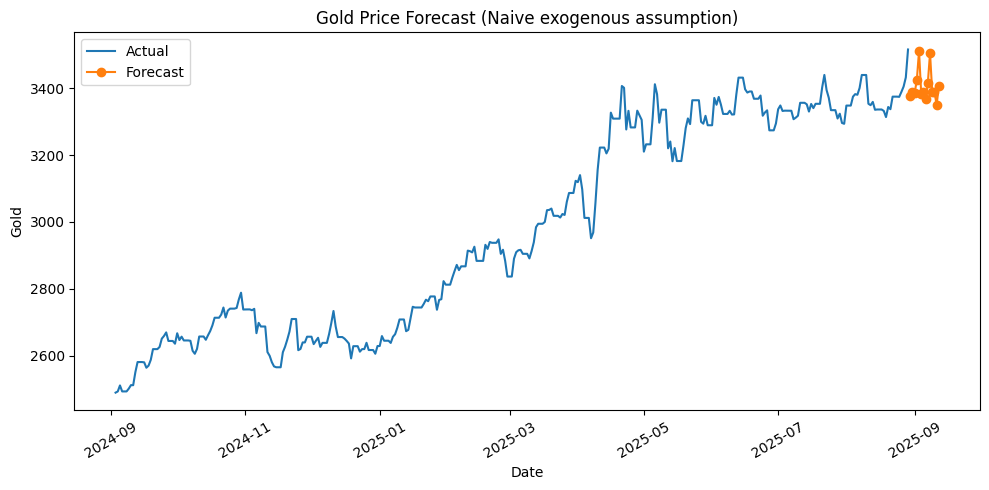

In [78]:
# Plot predicted vs actual
plt.figure(figsize=(10, 5))
plt.plot(df2["date"], df2["gold"], label="Actual")
plt.plot(fc_df["date"], fc_df["forecast_gold"], label="Forecast", marker="o")
plt.xticks(rotation=30)
plt.xlabel("Date")
plt.ylabel("Gold")
plt.title("Gold Price Forecast (Naive exogenous assumption)")
plt.legend()
plt.tight_layout()
plt.show()

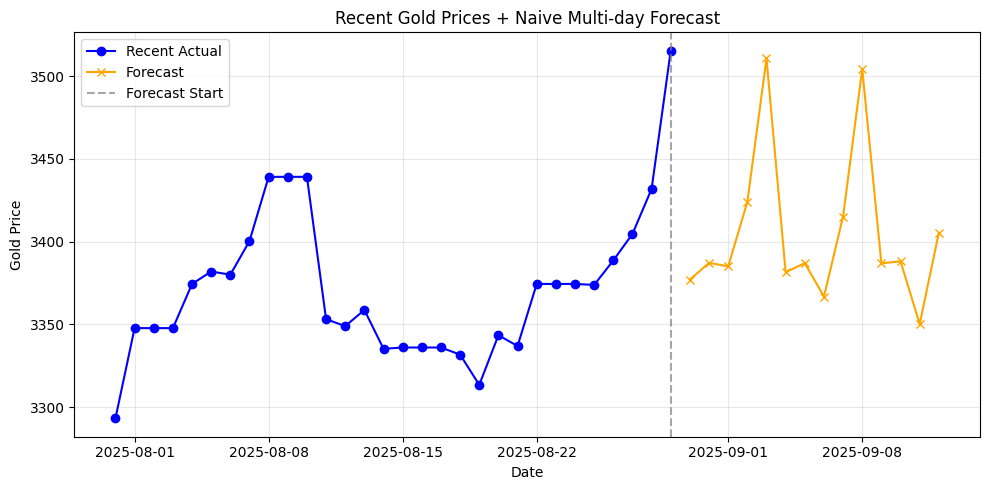

In [77]:
# Plot recent history + forecast
plt.figure(figsize=(10, 5))
plt.plot(df2["date"].iloc[-30:], df2[target].iloc[-30:], 
         label="Recent Actual", marker="o", color="blue")
plt.plot(fc_df["date"], fc_df["forecast_gold"], 
         label="Forecast", marker="x", color="orange")

# Mark the boundary between actual and forecast
plt.axvline(df2["date"].iloc[-1], color="gray", linestyle="--", alpha=0.7, label="Forecast Start")

plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Recent Gold Prices + Naive Multi-day Forecast")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()